In [19]:
import plotly.express as px
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.stats import probplot, shapiro, levene
import pandas as pd
from scipy import stats
import numpy as np
from statsmodels.sandbox.stats.multicomp import multipletests
import seaborn as sns

In [20]:

df = pd.read_parquet("../../data/benchmark/preprocessing/as_data")

In [21]:
df = df.groupby("sender_address", group_keys=False).apply(lambda x: x.sample(1))
df = df.groupby("receiver_address", group_keys=False).apply(lambda x: x.sample(1))

/var/folders/8k/8gwvwkzs4gb02y8rr95frc040000gn/T/ipykernel_2449/1858234736.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("sender_address", group_keys=False).apply(lambda x: x.sample(1))
/var/folders/8k/8gwvwkzs4gb02y8rr95frc040000gn/T/ipykernel_2449/1858234736.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("receiver_address", group_keys=False).apply(lambda x: x.sam

In [22]:
# Data imputation

numbers_of_na = df.isna().sum()

for index, number_of_na in enumerate(numbers_of_na):
    if number_of_na != 0:
        column_name = df.columns[index]
        print(f'{column_name} has {number_of_na} missing values')

In [23]:
# Location and dispersion

numeric_features_df = df.select_dtypes(include=['number'])

print(numeric_features_df.describe())
print("--------------------------------------")
print("mode:\n", numeric_features_df.mode())
print("--------------------------------------")
print("median:\n", numeric_features_df.median())
print('--------------------------------------')
print(
    "range:\n",
    numeric_features_df.max() - numeric_features_df.min(),
)

       block_number  transaction_index           fee  total_transferred_value  \
count  1.509700e+04       15097.000000  1.509700e+04             15097.000000   
mean   5.017204e+06          86.185600  1.282760e-03                21.461163   
std    4.724157e+05          68.830554  3.953002e-03               517.944083   
min    4.370031e+06           0.000000  2.100000e-14                 0.000000   
25%    4.901577e+06          30.000000  2.310000e-04                 0.051800   
50%    5.000534e+06          70.000000  4.200000e-04                 0.520000   
75%    5.158025e+06         129.000000  1.155000e-03                 4.780000   
max    9.122210e+06         378.000000  1.000000e-01             60000.000000   

       total_input_value    sent_value  received_value  avg_sent_value  \
count       1.509700e+04  1.509700e+04    15097.000000    1.509700e+04   
mean        2.146245e+01  2.146245e+01       21.461163    2.155146e+01   
std         5.179441e+02  5.179441e+02      517.

In [24]:
columns_to_plot = [
    "avg_sent_value",
    "avg_received_value",
    "sum_sent_value",
    "sum_received_value",
    "num_sent_transactions",
    "num_received_transactions",
    "avg_time_between_sent_transactions",
    "avg_time_between_received_transactions",
    "avg_fee_paid",
]

def plot_by_label(df, columns):
    for col in columns:
        
        # Boxplot
        box_fig = px.box(
            df,
            x="label",
            y=col,
            title=f"Box Plot for {col} by anomaly label",
            width=800,
            log_y=True,
        )
        box_fig.update_layout(height=400)
        box_fig.show()
        
        for label in [True, False]:
            subset = df[df["label"] == label]
            label_name = f"Label {label}"

            # Histogram
            hist_fig = px.histogram(
                subset,
                x=col,
                title=f"Histogram for {col} ({label_name})",
                opacity=0.8,
                log_y=True,
                width=800,
            )
            hist_fig.update_layout(height=400)
            hist_fig.show()

            # # Boxplot
            # box_fig = px.box(
            #     subset,
            #     y=col,
            #     title=f"Box Plot for {col} ({label_name})",
            #     width=800,
            #     log_y=True
            # )
            # box_fig.update_layout(height=400)
            # box_fig.show()
            
plot_by_label(df, columns_to_plot)

In [25]:
outliers_df = numeric_features_df.copy()
outliers_df["bitcoin"] = df["network_name"] == "bitcoin"
outliers_df["ethereum"] = df["network_name"] == "ethereum"
outliers_df["label"] = df["label"]

# Scale data
scaler = MinMaxScaler()
scaled_outliers = scaler.fit_transform(outliers_df.drop(columns=["label"]))

lof = LocalOutlierFactor(n_neighbors=2, contamination="auto")

outliers = lof.fit_predict(scaled_outliers)
outliers_df["outliers"] = outliers

print(outliers_df[outliers_df["outliers"] == -1])
print(outliers_df[(outliers_df["outliers"] == -1) & (outliers_df["label"] == True)])

       block_number  transaction_index       fee  total_transferred_value  \
37222       5127015                134  0.000357                  37.2000   
37406       5128287                 80  0.001575                 189.0000   
15695       4844277                130  0.001000                   0.0060   
24465       4984685                 95  0.000210                   9.4700   
11062       4464657                 48  0.000294                   0.0917   
...             ...                ...       ...                      ...   
21797       4981166                101  0.001800                   0.1630   
41117       5164918                 58  0.000147                   0.0050   
45177       5236423                172  0.000147                   1.9000   
29245       5033585                 32  0.000844                   2.1000   
16152       4858215                347  0.001601                  92.0000   

       total_input_value  sent_value  received_value  avg_sent_value  \
372

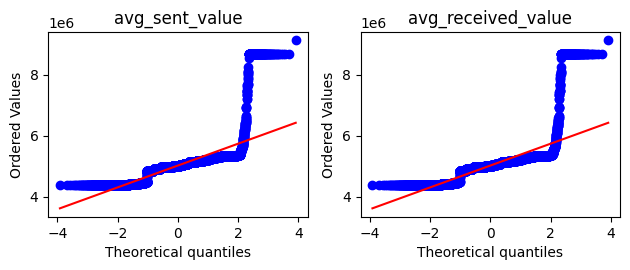

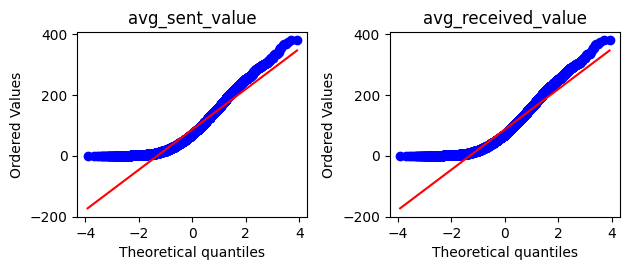

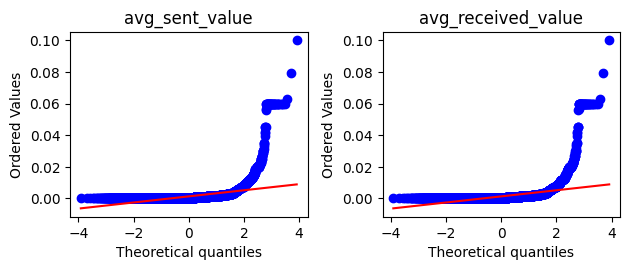

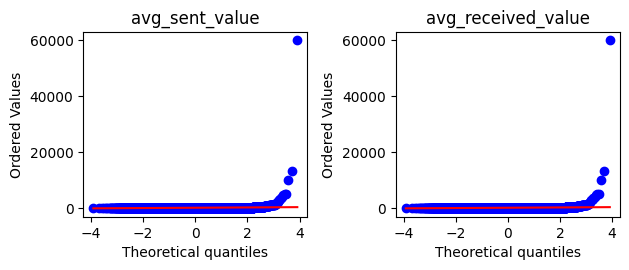

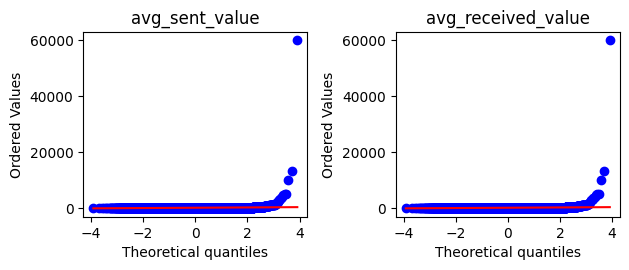

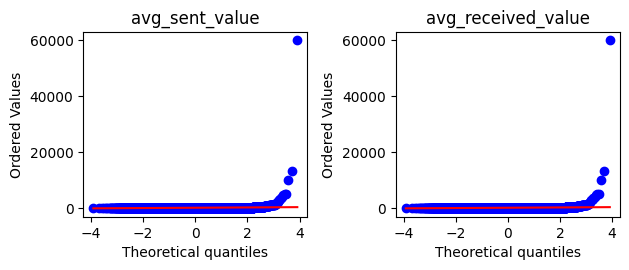

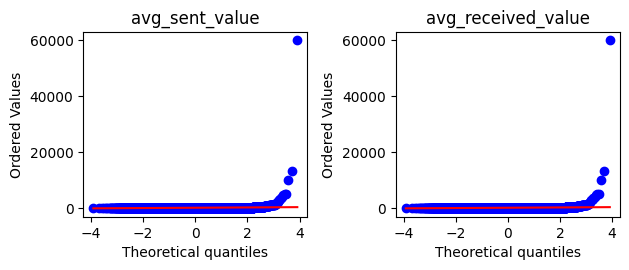

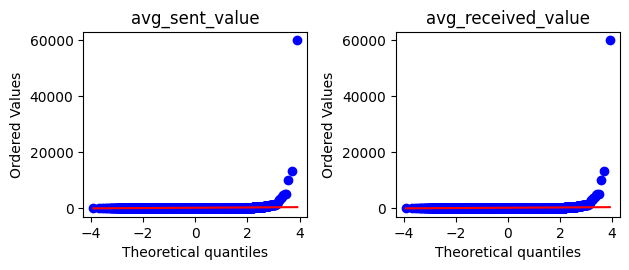

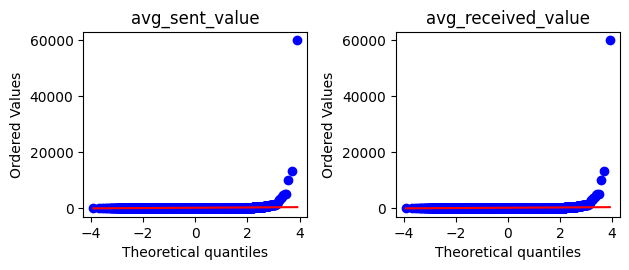

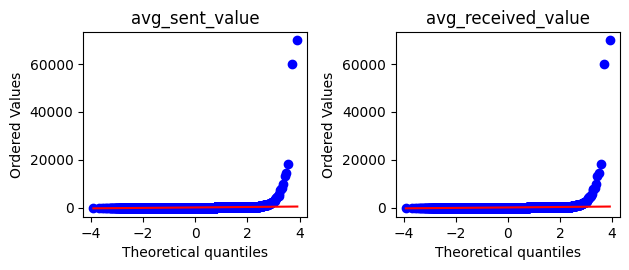

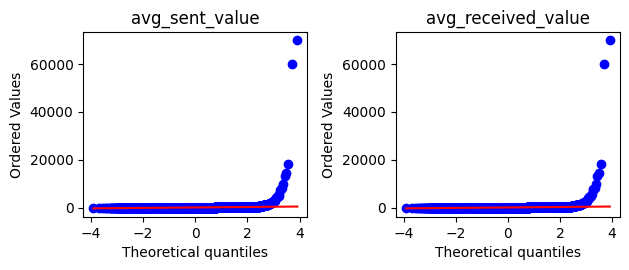

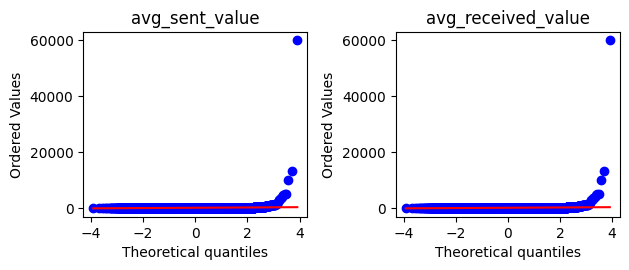

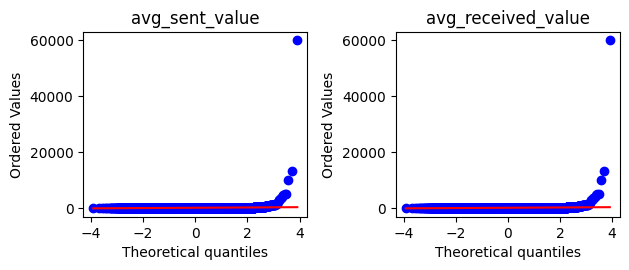

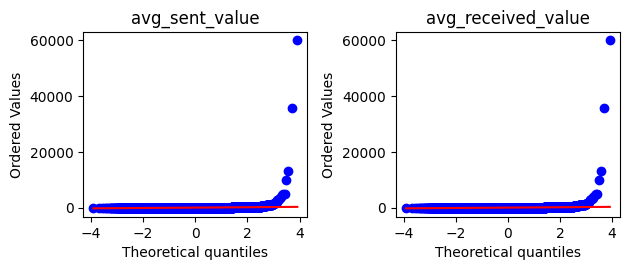

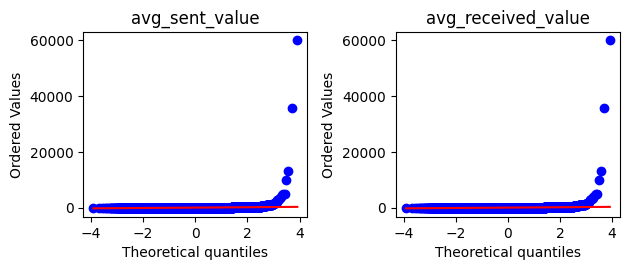

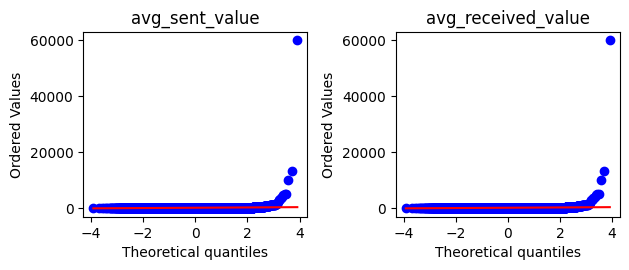

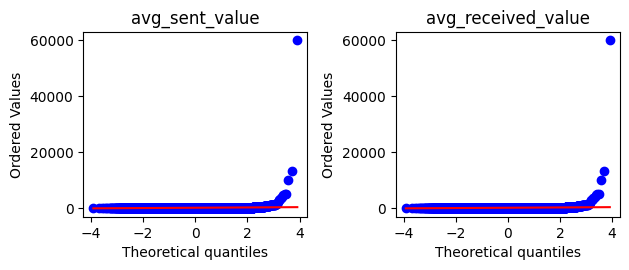

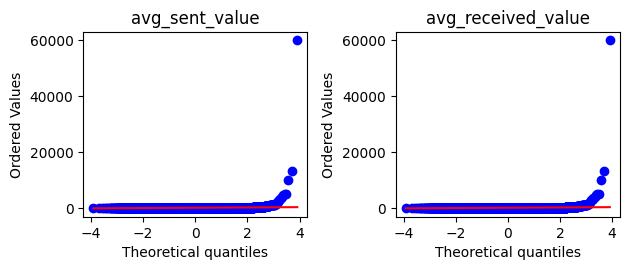

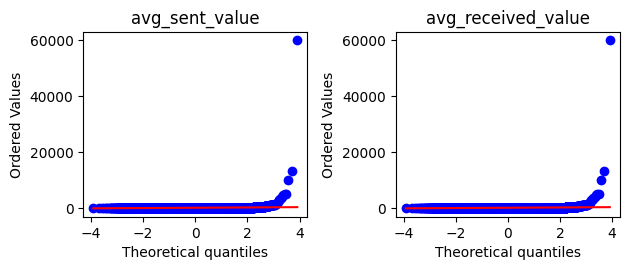

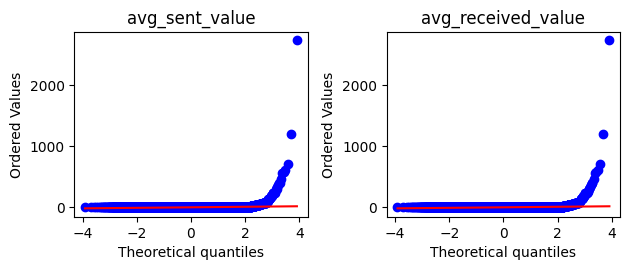

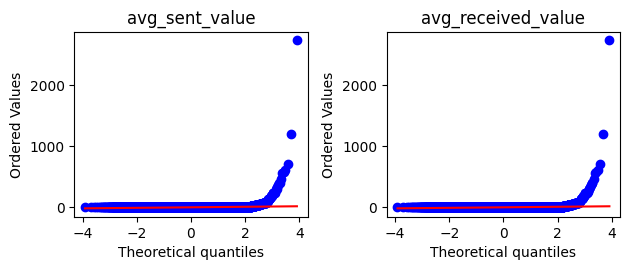

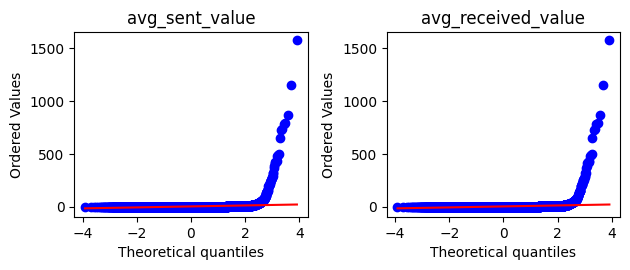

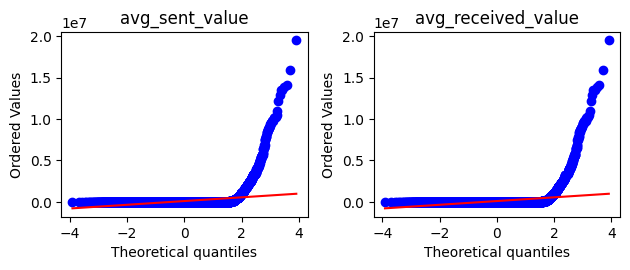

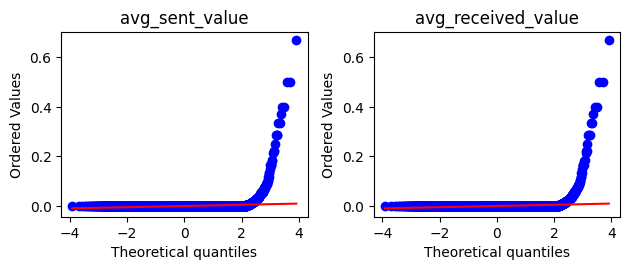

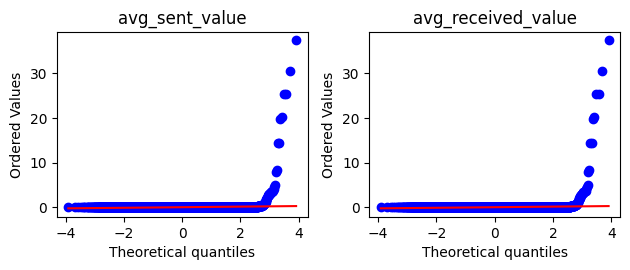

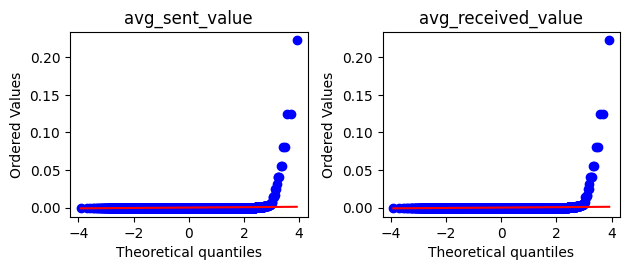

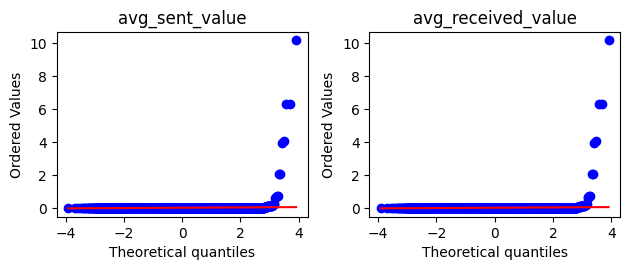

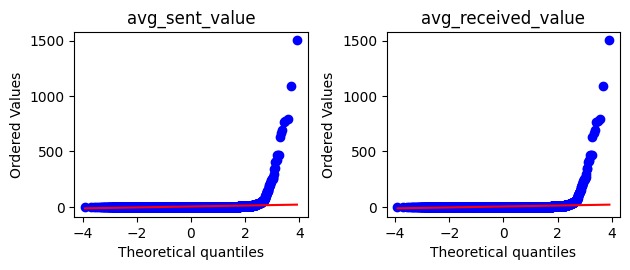

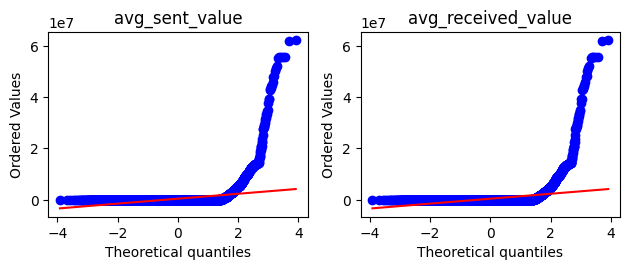

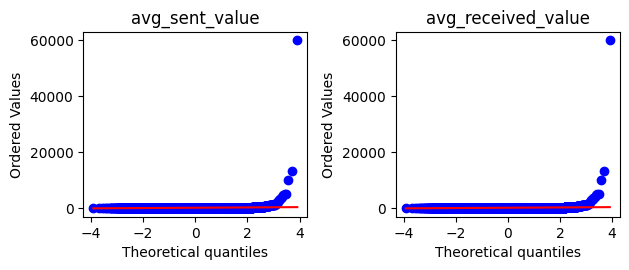

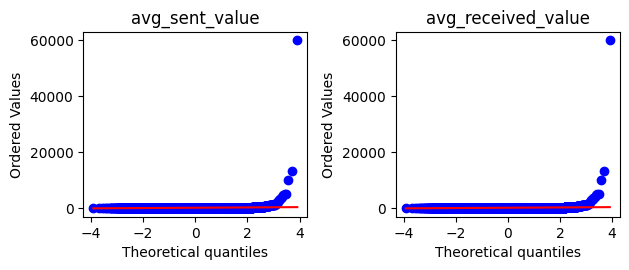

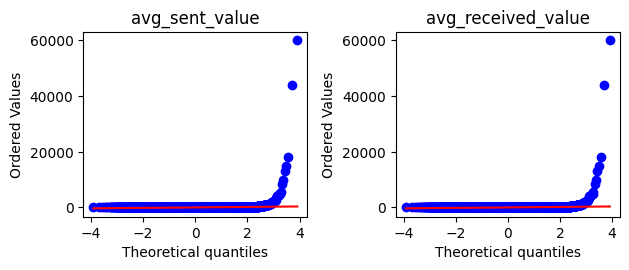

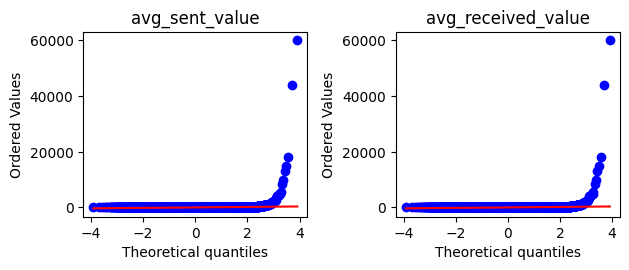

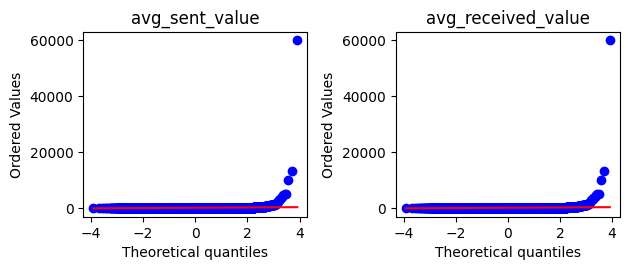

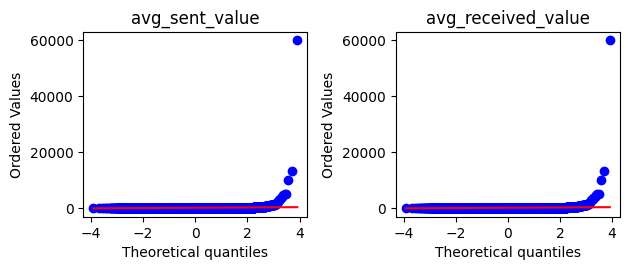

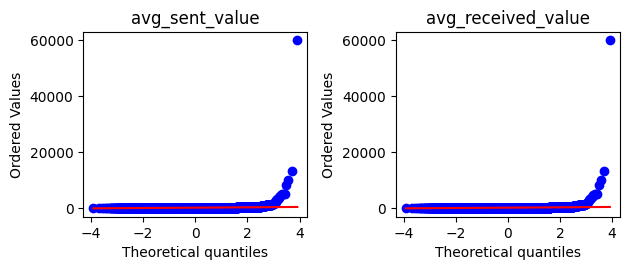

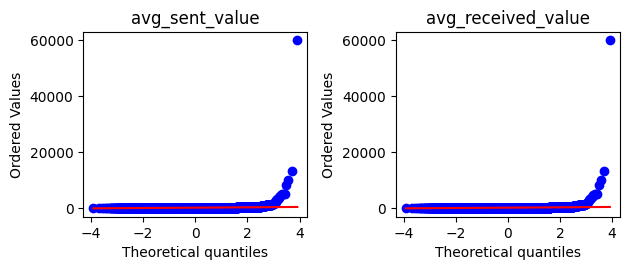

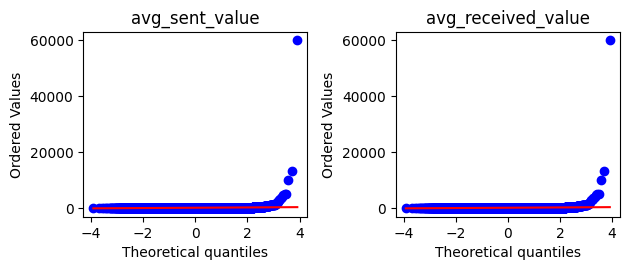

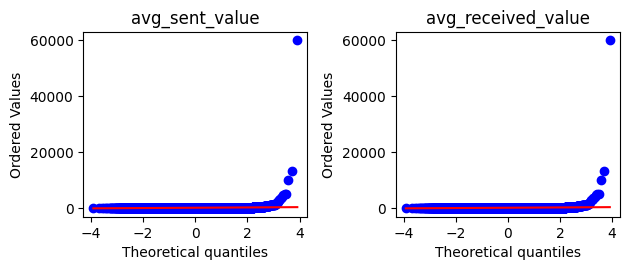

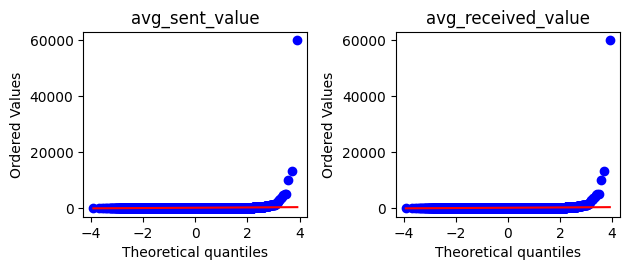

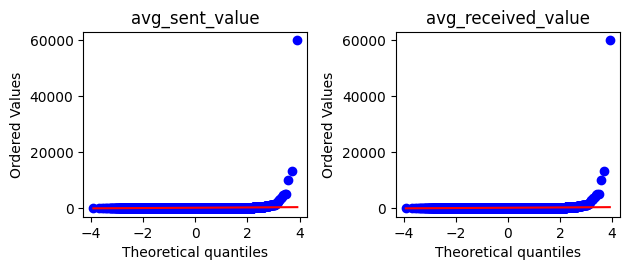

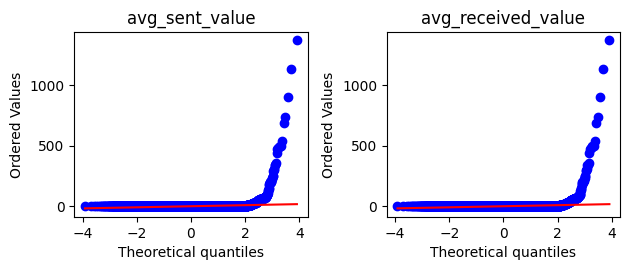

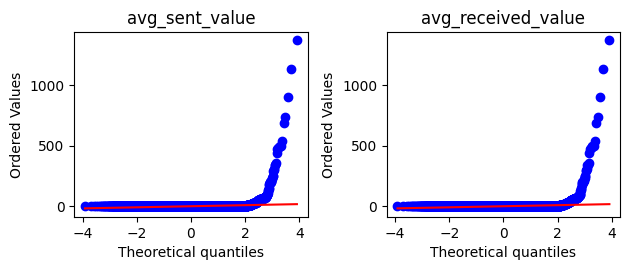

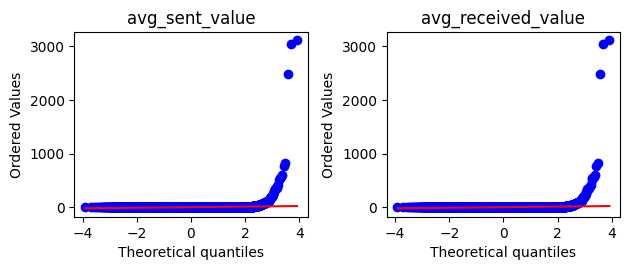

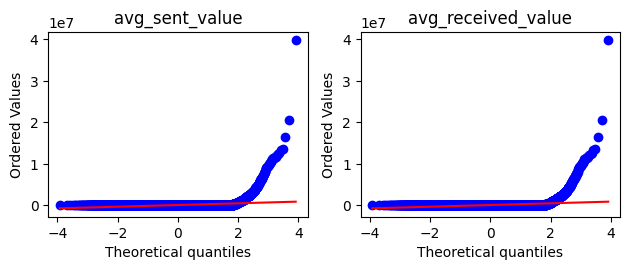

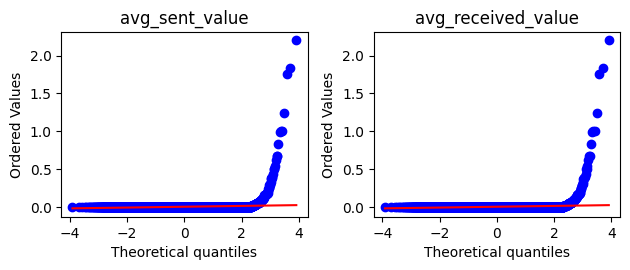

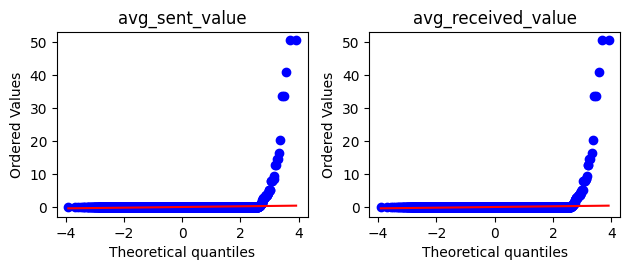

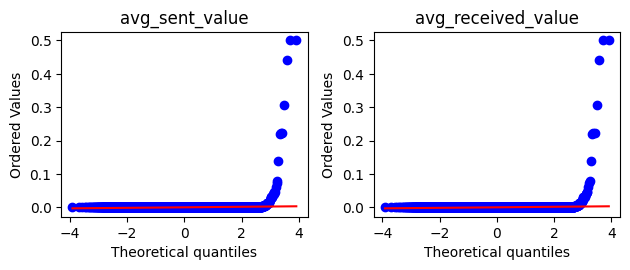

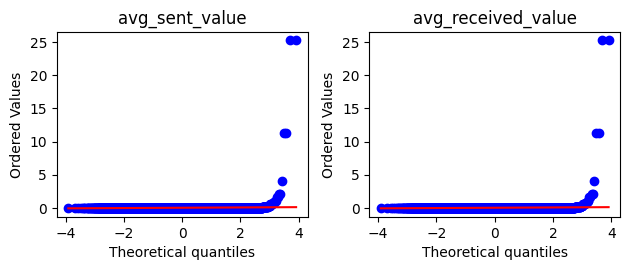

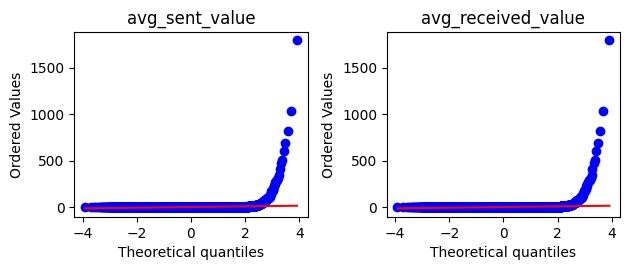

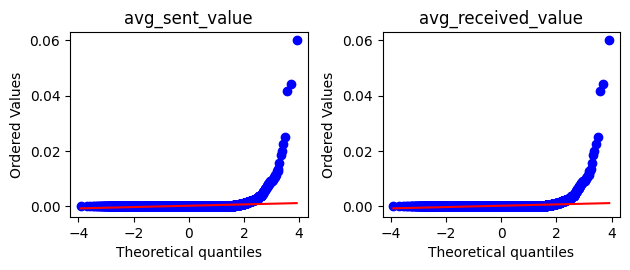

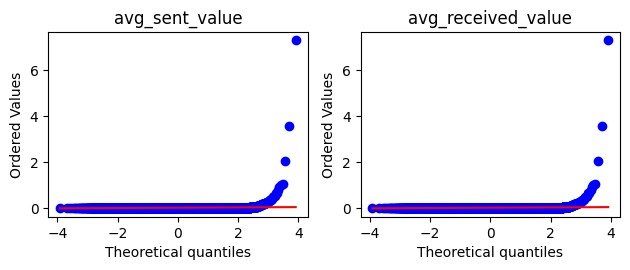

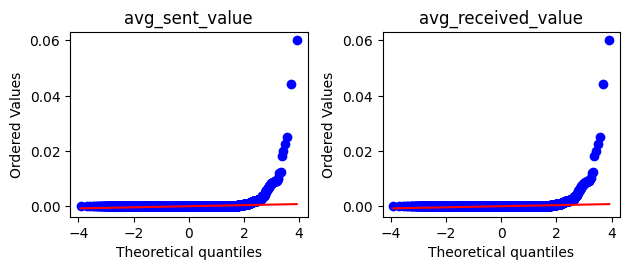

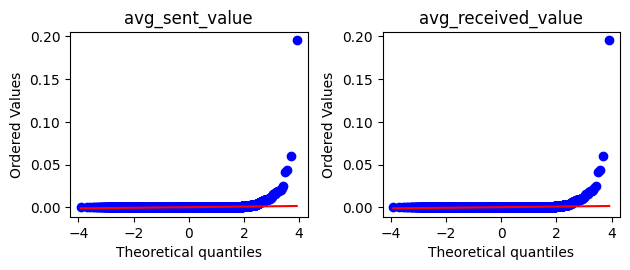

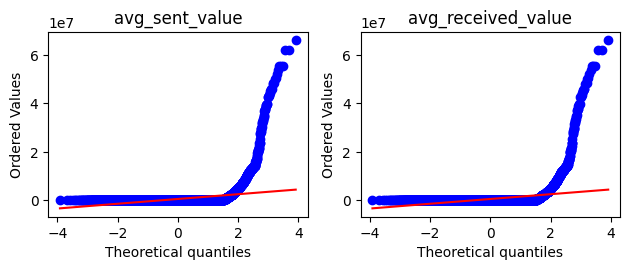

In [26]:
# QQ-plot

for column in numeric_features_df.columns:
    fig = plt.figure()

    ax = fig.add_subplot(221)
    res = probplot(numeric_features_df[column].values, plot=ax)
    ax.set_title("avg_sent_value")

    ax = fig.add_subplot(222)
    res = probplot(numeric_features_df[column].values, plot=plt)
    ax.set_title("avg_received_value")

    plt.tight_layout()
    plt.show()

In [27]:
# Normality testing

for column in numeric_features_df.columns:
    anomaly_stat, anomaly_p_value = shapiro(
        df[df["label"] == True][column]
    )
    non_anomaly_stat, non_anomaly_p_value = shapiro(
        df[df["label"] == False][column]
    )

    if anomaly_p_value > 0.05:
        print(f"For anomalies {column} is normally distributed")
    else:
        print(f"For anomalies {column} is not normally distributed")
    if non_anomaly_p_value > 0.05:
        print(f"For non anomalies {column} is normally distributed")
    else:
        print(f"For non anomalies {column} is not normally distributed")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 14846.



For anomalies block_number is not normally distributed
For non anomalies block_number is not normally distributed
For anomalies transaction_index is not normally distributed
For non anomalies transaction_index is not normally distributed
For anomalies fee is not normally distributed
For non anomalies fee is not normally distributed
For anomalies total_transferred_value is not normally distributed
For non anomalies total_transferred_value is not normally distributed
For anomalies total_input_value is not normally distributed
For non anomalies total_input_value is not normally distributed
For anomalies sent_value is not normally distributed
For non anomalies sent_value is not normally distributed
For anomalies received_value is not normally distributed
For non anomalies received_value is not normally distributed
For anomalies avg_sent_value is not normally distributed
For non anomalies avg_sent_value is not normally distributed
For anomalies avg_total_value_for_sender is not normally dis

In [28]:
# Variance homogenity test

for column in numeric_features_df.columns:
    column_levene_test = levene(
        df[df["label"] == True][column],
        df[df["label"] == False][column],
    )

    if column_levene_test.pvalue > 0.05:
        print(f"Variance homogenity for anomalies {column} and non anomalies {column} is confirmed")
    else:
        print(
            f"Variance homogenity for anomalies {column} and non anomalies {column} is not confirmed"
        )

Variance homogenity for anomalies block_number and non anomalies block_number is not confirmed
Variance homogenity for anomalies transaction_index and non anomalies transaction_index is not confirmed
Variance homogenity for anomalies fee and non anomalies fee is confirmed
Variance homogenity for anomalies total_transferred_value and non anomalies total_transferred_value is confirmed
Variance homogenity for anomalies total_input_value and non anomalies total_input_value is confirmed
Variance homogenity for anomalies sent_value and non anomalies sent_value is confirmed
Variance homogenity for anomalies received_value and non anomalies received_value is confirmed
Variance homogenity for anomalies avg_sent_value and non anomalies avg_sent_value is confirmed
Variance homogenity for anomalies avg_total_value_for_sender and non anomalies avg_total_value_for_sender is confirmed
Variance homogenity for anomalies sum_sent_value and non anomalies sum_sent_value is confirmed
Variance homogenity fo

In [29]:
# Univariate analysis

def bootstrap_ci(
    df, variable, classes, repetitions=1000, alpha=0.05, random_state=None
):
    df = df[[variable, classes]]
    bootstrap_sample_size = len(df)

    mean_diffs = []
    for i in range(repetitions):
        bootstrap_sample = df.sample(
            n=bootstrap_sample_size, replace=True, random_state=random_state
        )
        mean_diff = (
            bootstrap_sample.groupby(classes).mean().iloc[1, 0]
            - bootstrap_sample.groupby(classes).mean().iloc[0, 0]
        )
        mean_diffs.append(mean_diff)

    left = np.percentile(mean_diffs, alpha / 2 * 100)
    right = np.percentile(mean_diffs, 100 - alpha / 2 * 100)
    return round(left, 2), round(right, 2)


p_values = {}
statistics = {}
stat_df = pd.DataFrame(
    columns=["u-value", "p-value", "ci_low", "ci_high", "significant"],
    index=numeric_features_df.columns,
)

for column in numeric_features_df:
    u_value, p_value = stats.mannwhitneyu(
        df[df["label"] == True][column], df[df["label"] == False][column]
    )
    ci_low, ci_high = bootstrap_ci(df, column, "label", repetitions=100)
    stat_df.loc[column] = [u_value, p_value, ci_low, ci_high, p_value < 0.05]
    p_values[column] = p_value
    statistics[column] = u_value

print("Mann-Whitney U test for significance:\n", stat_df, "\n")
# Null Hypothesis (H0):
# The null hypothesis for the Mann-Whitney U test is that there is no difference between the distributions of the two groups being compared.
# Alternative Hypothesis (H1):
# The alternative hypothesis is that there is a difference between the distributions of the two groups.

stat_df = pd.DataFrame(
    columns=["u-value", "p-value", "significant"], index=numeric_features_df.columns
)

for column in numeric_features_df.columns:
    unique_values = set(
        df[df["label"] == True][column].unique()
    ).union(df[df["label"] == False][column].unique())

    counts_fraud = (
        df[df["label"] == True][column]
        .value_counts()
        .reindex(unique_values, fill_value=0)
    )
    counts_no_fraud = (
        df[df["label"] == False][column]
        .value_counts()
        .reindex(unique_values, fill_value=0)
    )

    contingency_table = pd.DataFrame({"fraud": counts_fraud, "no_fraud": counts_no_fraud})

    chi2_stat, p_value, _, _ = stats.chi2_contingency(contingency_table)
    stat_df.loc[column] = [chi2_stat, p_value, p_value < 0.05]
    p_values[column] = p_value

print("Chi-square test for significance:\n", stat_df)
# Null Hypothesis (H0):
# The null hypothesis for the chi-square test is that there is no significant difference between the observed and expected frequencies in the distribution of a categorical variable.
# Alternative Hypothesis (H1):
# The alternative hypothesis is that there is a significant difference between the observed and expected frequencies in the distribution of a categorical variable.

Mann-Whitney U test for significance:
                                           u-value   p-value      ci_low  \
block_number                            2924258.5       0.0   637282.78   
transaction_index                       1437697.5       0.0      -34.02   
fee                                     2017816.5  0.023828        -0.0   
total_transferred_value                 1490666.0       0.0      -27.59   
total_input_value                       1520368.5  0.000001      -26.75   
sent_value                              1520368.5  0.000001       -28.1   
received_value                          1490666.0       0.0       -27.9   
avg_sent_value                          1750021.5  0.098428      -26.59   
avg_total_value_for_sender              1746059.5  0.087176      -27.09   
sum_sent_value                          1969747.0  0.119598      -21.81   
sum_total_value_for_sender              1961978.5  0.148996       -29.0   
min_sent_value                          1314536.0       0.0  

In [30]:
# Multiple testing correction

stat_df = pd.DataFrame(
    columns=["before", "Bonferroni", "Benjamini-Hochberg", "significant"],
    index=p_values.keys(),
)

multipletests_p_values = multipletests(
    list(p_values.values()), alpha=0.05, method="bonferroni"
)[1]
bonferroni_p_values = dict(zip(list(p_values.keys()), multipletests_p_values))

multipletests_p_values = multipletests(
    list(p_values.values()), alpha=0.05, method="fdr_bh"
)[1]
bh_p_values = dict(zip(list(p_values.keys()), multipletests_p_values))

stat_df["before"] = pd.Series(p_values)
stat_df["Bonferroni"] = pd.Series(bonferroni_p_values)
stat_df["Benjamini-Hochberg"] = pd.Series(bh_p_values)
stat_df["significant"] = stat_df["Benjamini-Hochberg"] < 0.05

print("Multiple testing correction:\n", stat_df)

Multiple testing correction:
                                                before     Bonferroni  \
block_number                            6.678299e-245  3.673064e-243   
transaction_index                        8.048793e-01   1.000000e+00   
fee                                      5.031356e-96   2.767246e-94   
total_transferred_value                  2.310467e-62   1.270757e-60   
total_input_value                        2.401186e-06   1.320653e-04   
sent_value                               2.401186e-06   1.320653e-04   
received_value                           2.310467e-62   1.270757e-60   
avg_sent_value                           6.681851e-07   3.675018e-05   
avg_total_value_for_sender              2.348785e-202  1.291832e-200   
sum_sent_value                           8.130294e-07   4.471661e-05   
sum_total_value_for_sender              5.115052e-180  2.813279e-178   
min_sent_value                           4.434721e-05   2.439097e-03   
min_total_value_for_sender        

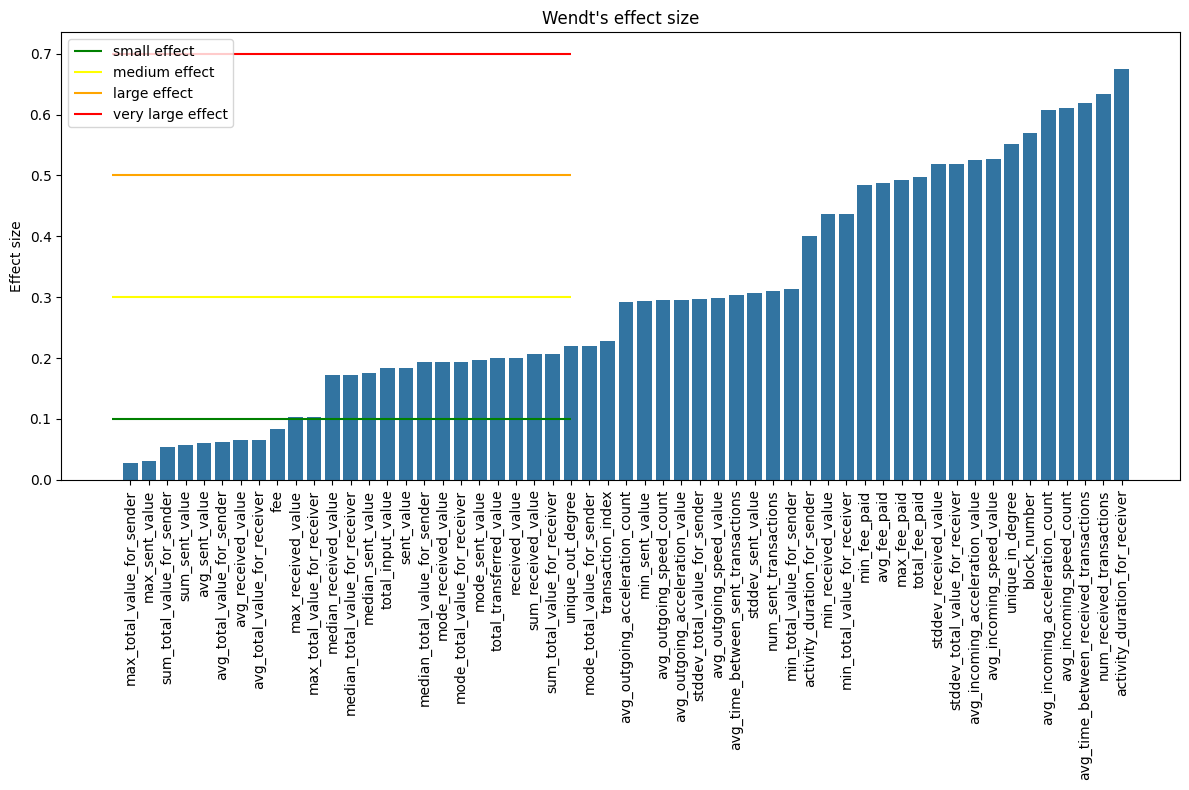

In [31]:
# Effect size

def wendt_effect_size(u1, n1, n2):
    u2 = n1 * n2 - u1
    return 1 - ((2 * min(u1, u2)) / (n1 * n2))


for column in columns_to_plot:
    u_value, p_value = stats.mannwhitneyu(
        df[df["label"] == True][column], df[df["label"] == False][column]
    )
    statistics[column] = u_value

stats_wendt = {
    k: np.abs(
        wendt_effect_size(
            v,
            df[df["label"] == True][column].shape[0],
            df[df["label"] == False][column].shape[0],
        )
    )
    for k, v in statistics.items()
}

plt.figure(figsize=(12, 8))

sns.barplot(
    x=list(stats_wendt.keys()),
    y=list(stats_wendt.values()),
    order=sorted(stats_wendt, key=stats_wendt.get),
)
plt.xticks(rotation=90)
plt.title("Wendt's effect size")
plt.hlines(y=0.1, color="green", label="small effect", xmin=-1, xmax=24)
plt.hlines(y=0.3, color="yellow", label="medium effect", xmin=-1, xmax=24)
plt.hlines(y=0.5, color="orange", label="large effect", xmin=-1, xmax=24)
plt.hlines(y=0.7, color="red", label="very large effect", xmin=-1, xmax=24)
plt.ylabel("Effect size")
plt.legend()
plt.tight_layout()
plt.show()

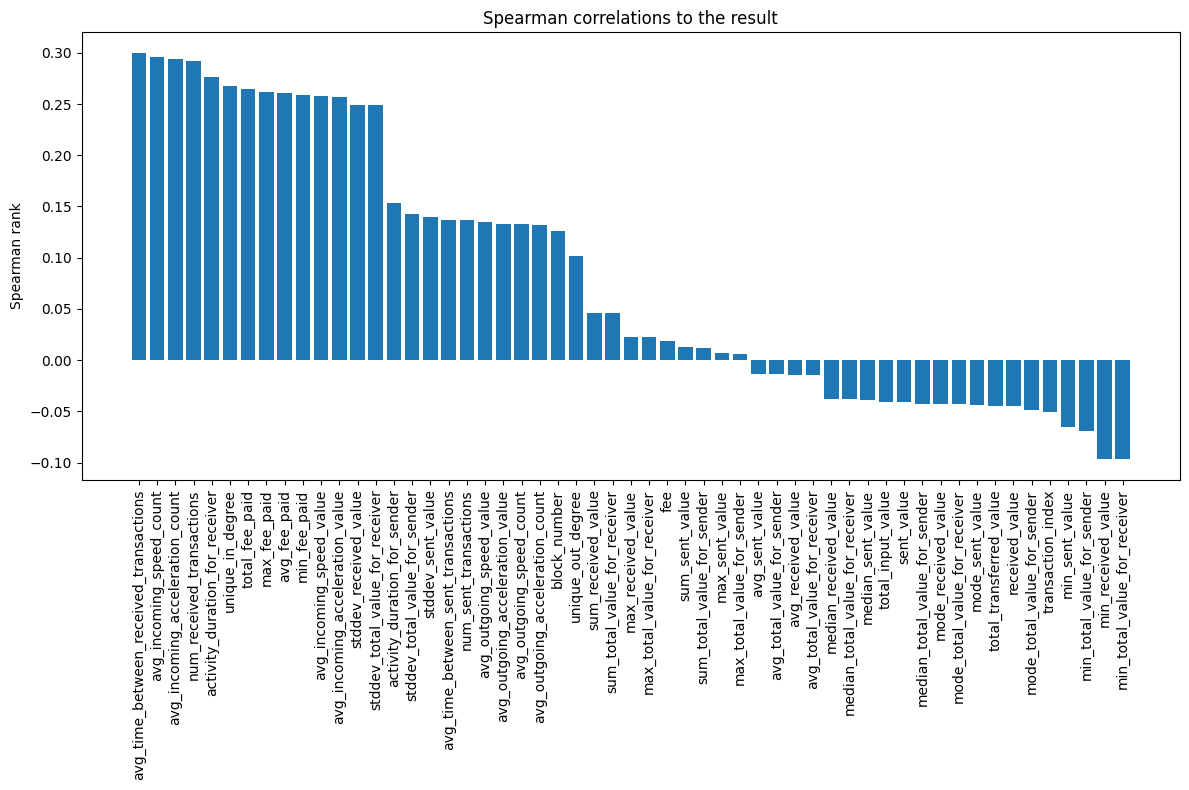

In [32]:
correlations = {}

for column in numeric_features_df.columns:
    correlations[column] = df[["label", column]].corr("spearman").iloc[0, 1]

correlations = {
    k: v
    for k, v in sorted(correlations.items(), reverse=True, key=lambda item: item[1])
}

plt.figure(figsize=(12, 8))

plt.bar(correlations.keys(), correlations.values())
plt.title("Spearman correlations to the result")
plt.ylabel("Spearman rank")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

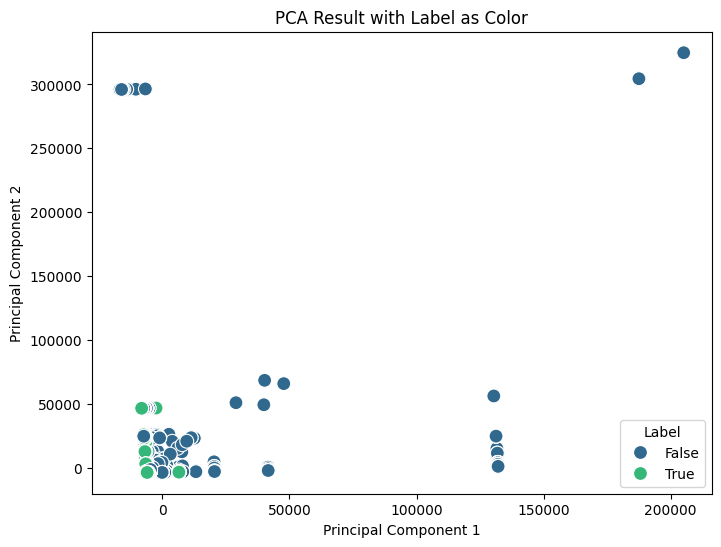

In [33]:
# PCA
import pandas as pd
from sklearn.decomposition import PCA

preprocessed_df = pd.read_parquet("../../data/benchmark/testing/eth")

labels = preprocessed_df["label"]
preprocessed_df.drop("label", axis=1, inplace=True)

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(preprocessed_df)

pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
pca_df["label"] = labels

# Plot the PCA result
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pca_df, x="PC1", y="PC2", hue="label", palette="viridis", s=100
)
plt.title("PCA Result with Label as Color")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Label")
plt.show()